### Testing GA Hyperparameter Tuning

Dependencies:
```
numpy
pandas 
matplotlib
sklearn
```

In [1]:
from genetic_algorithm import GeneticAlgorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay



##### Load data 

In [2]:
def get_analytics(y_test, y_pred):
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='weighted')
   recall = recall_score(y_test, y_pred, average='weighted')
   f1 = f1_score(y_test, y_pred, average='weighted')
   cm = confusion_matrix(y_test, y_pred)
   report = classification_report(y_test, y_pred, output_dict=True)
   cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
   
   print("Accuracy: ", accuracy)
   print("Precision: ", precision)
   print("Recall: ", recall)
   print("F1 Score: ", f1)
   
   print("Classification Report:")
   print(report)
   cm_display.plot(cmap=plt.cm.Blues)
   plt.title("Confusion Matrix")
   plt.show()
   
   

In [3]:
def prepare_data(X, y):
   # Splits and scales the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   y_train_binary = np.where(y_train > np.median(y_train), 1, 0)
   y_test_binary = np.where(y_test > np.median(y_train), 1, 0)
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   return X_train_scaled, X_test_scaled, y_train_binary, y_test_binary
   
   
   
   
   

In [4]:
# Load Diabetes Data 
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X_train_scaled, X_test_scaled, y_train_binary, y_test_binary = prepare_data(X, y)




In [15]:
from sklearn.datasets import load_iris
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV

## Testing

For testing, 3 different models were used
- Decision Trees
- SVM
- Logistic Regression

4 Different Hyperparameter tuning methods were used
- Our Genetic Algorithm Hyperparameter Tuning Method 
- Grid Search
- Randomized Search
- Halving Grid Search

For each model, across all of the hyperparameter tuning methods, the same set of parameters was used for each one and the same parameters were used for each genetic algorithm

### Decision Tree

In [5]:
# Using the same params for Grid Search and Genetic Algorithm
# decision tree param space
param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
}

In [ ]:
dt = DecisionTreeClassifier()


ga = GeneticAlgorithm(modelToTune=dt, 
                      param_space=param_space, 
                      verbose=0,
                      population_size=75,
                      generations=100,
                      mutation_prob=0.75,
                      crossover_prob=0.5,
                      cv=5,
                      scoring='accuracy'
                      ) 
start = time.time()
ga.run(X_train_scaled, y_train_binary)
end = time.time()
print(f"Genetic Algorithm took {end - start:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm: {ga.best_params_}")
print(f"Best score from Genetic Algorithm: {ga.best_score_:.4f}")

Genetic Algorithm took 74.71 seconds
Best parameters found from Genetic Algorithm: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None, 'max_leaf_nodes': 40, 'splitter': 'random', 'class_weight': None}
Best score from Genetic Algorithm: 0.7475


Accuracy:  0.7303370786516854
Precision:  0.7382101998386749
Recall:  0.7303370786516854
F1 Score:  0.730950568614308
Classification Report:
{'0': {'precision': 0.7906976744186046, 'recall': 0.6938775510204082, 'f1-score': 0.7391304347826086, 'support': 49.0}, '1': {'precision': 0.6739130434782609, 'recall': 0.775, 'f1-score': 0.7209302325581395, 'support': 40.0}, 'accuracy': 0.7303370786516854, 'macro avg': {'precision': 0.7323053589484327, 'recall': 0.7344387755102041, 'f1-score': 0.7300303336703741, 'support': 89.0}, 'weighted avg': {'precision': 0.7382101998386749, 'recall': 0.7303370786516854, 'f1-score': 0.730950568614308, 'support': 89.0}}


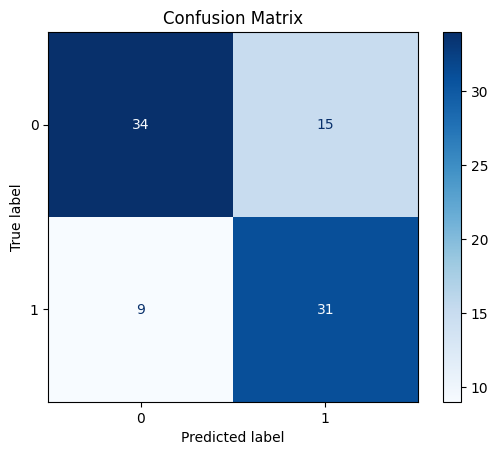

In [13]:
params = ga.best_params_
dt_clf = DecisionTreeClassifier(**params).fit(X_train_scaled, y_train_binary)
y_pred = dt_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

In [20]:
print(ga.best_score_)

0.7475396825396825


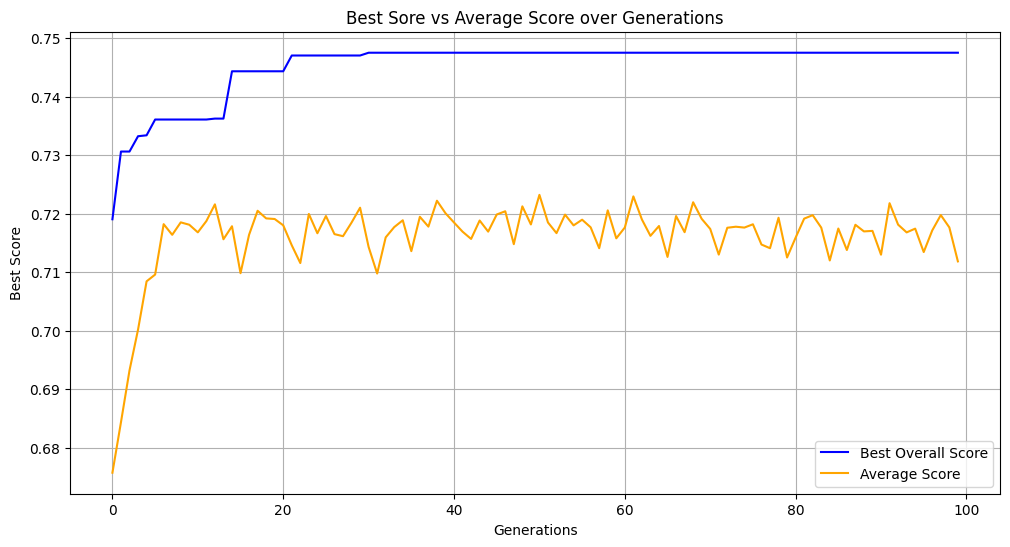

In [ ]:
# Creating a graph of best scores over time 
ga_scores = ga.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [22]:
dt2 = DecisionTreeClassifier()

grid = GridSearchCV(dt2, param_space, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()
print(f"Grid Search took {end2 - start2:.2f} seconds")
print(f"Best parameters from Grid Search: {grid.best_params_}")
print(f"Best score from Grid Search: {grid.best_score_:.4f}")

Grid Search took 1220.16 seconds
Best parameters from Grid Search: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 18, 'min_samples_split': 2, 'splitter': 'random'}
Best score from Grid Search: 0.7677


Accuracy:  0.6853932584269663
Precision:  0.6843148850314816
Recall:  0.6853932584269663
F1 Score:  0.6845059060789398
Classification Report:
{'0': {'precision': 0.7058823529411765, 'recall': 0.7346938775510204, 'f1-score': 0.72, 'support': 49.0}, '1': {'precision': 0.6578947368421053, 'recall': 0.625, 'f1-score': 0.6410256410256411, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.681888544891641, 'recall': 0.6798469387755102, 'f1-score': 0.6805128205128206, 'support': 89.0}, 'weighted avg': {'precision': 0.6843148850314816, 'recall': 0.6853932584269663, 'f1-score': 0.6845059060789398, 'support': 89.0}}


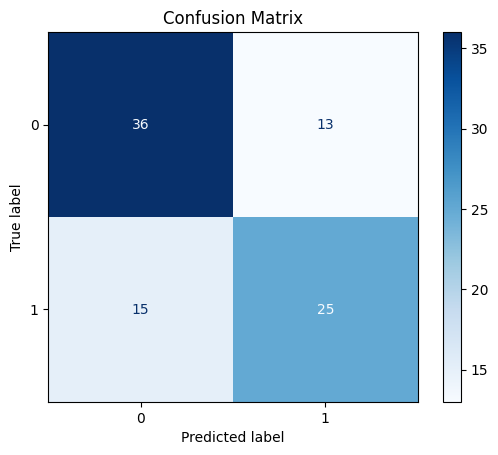

In [24]:
dt2 = grid.best_estimator_
y_pred2 = dt2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

In [25]:
print(grid.best_score_)

0.7677263581488933


##### Randomized Search

In [18]:
dt3 = DecisionTreeClassifier()

rand = RandomizedSearchCV(dt3, param_space, n_iter=7500, cv=5, n_jobs=-1, scoring='accuracy')
start3 = time.time()
rand.fit(X_train_scaled, y_train_binary)
end3 = time.time()
print(f"Randomized Search took {end3 - start3:.2f} seconds")
print(f"Best parameters from Randomized Search: {rand.best_params_}")
print(f"Best score from Randomized Search: {rand.best_score_:.4f}")

Randomized Search took 5.73 seconds
Best parameters from Randomized Search: {'splitter': 'best', 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_leaf_nodes': 10, 'max_features': 0.5, 'max_depth': 9, 'criterion': 'gini', 'class_weight': 'balanced'}
Best score from Randomized Search: 0.7510


Accuracy:  0.6853932584269663
Precision:  0.6897514470548178
Recall:  0.6853932584269663
F1 Score:  0.6861901346720854
Classification Report:
{'0': {'precision': 0.7333333333333333, 'recall': 0.673469387755102, 'f1-score': 0.7021276595744681, 'support': 49.0}, '1': {'precision': 0.6363636363636364, 'recall': 0.7, 'f1-score': 0.6666666666666666, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.6848484848484848, 'recall': 0.6867346938775509, 'f1-score': 0.6843971631205674, 'support': 89.0}, 'weighted avg': {'precision': 0.6897514470548178, 'recall': 0.6853932584269663, 'f1-score': 0.6861901346720854, 'support': 89.0}}


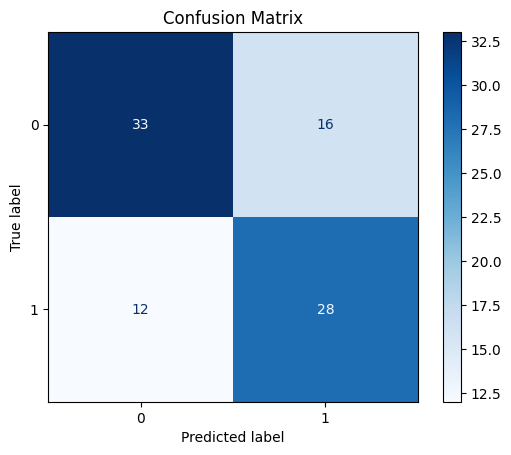

In [19]:
dt3 = rand.best_estimator_
y_pred3 = dt3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

In [26]:
print(rand.best_score_)

0.7509859154929578


##### Halving Grid Search

In [28]:
dt4 = DecisionTreeClassifier()
start4 = time.time()
halving_grid = HalvingGridSearchCV(dt4, param_space, cv=5, n_jobs=-1, scoring='accuracy')
halving_grid.fit(X_train_scaled, y_train_binary)
end4 = time.time()
print(f"Halving Grid Search took {end4 - start4:.2f} seconds")
print(f"Best parameters from Halving Grid Search: {halving_grid.best_params_}")
print(f"Best score from Halving Grid Search: {halving_grid.best_score_}")


Halving Grid Search took 2153.46 seconds
Best parameters from Halving Grid Search: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.7, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'splitter': 'best'}
Best score from Halving Grid Search: 0.825873015873016


Accuracy:  0.7415730337078652
Precision:  0.7475598683463853
Recall:  0.7415730337078652
F1 Score:  0.7422268653746384
Classification Report:
{'0': {'precision': 0.7954545454545454, 'recall': 0.7142857142857143, 'f1-score': 0.7526881720430108, 'support': 49.0}, '1': {'precision': 0.6888888888888889, 'recall': 0.775, 'f1-score': 0.7294117647058823, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7421717171717171, 'recall': 0.7446428571428572, 'f1-score': 0.7410499683744465, 'support': 89.0}, 'weighted avg': {'precision': 0.7475598683463853, 'recall': 0.7415730337078652, 'f1-score': 0.7422268653746384, 'support': 89.0}}


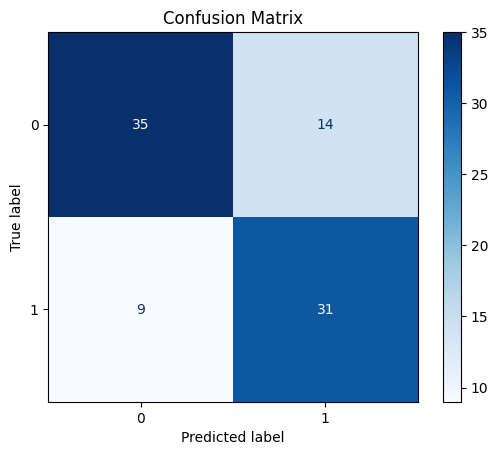

In [31]:
dt4 = halving_grid.best_estimator_
y_pred4 = dt4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [35]:
svm_param_space = {
    'C': list(np.logspace(-5, 3, 15)), 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': range(2, 10),  
    'coef0': list(np.linspace(0, 1, 5)), 
    'shrinking': [True, False], 
    'tol': list(np.logspace(-5, -1, 5))  
}

##### Genetic Algorithm Search

In [70]:
svm1 = SVC()
ga_svm = GeneticAlgorithm(modelToTune=svm1,
                          param_space=svm_param_space,
                           verbose=0,
                           population_size=75,
                           generations=100,
                           mutation_prob=0.75,
                           crossover_prob=0.5,
                           cv=5,
                           scoring='accuracy'
                           )
start5 = time.time()
ga_svm.run(X_train_scaled, y_train_binary)
end5 = time.time()
print(f"Genetic Algorithm for SVM took {end5 - start5:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm for SVM: {ga_svm.best_params_}")
print(f"Best score from Genetic Algorithm for SVM: {ga_svm.best_score_}")

                           

Genetic Algorithm for SVM took 160.09 seconds
Best parameters found from Genetic Algorithm for SVM: {'C': np.float64(0.007196856730011514), 'kernel': 'linear', 'gamma': 'auto', 'degree': 6, 'coef0': np.float64(1.0), 'shrinking': False, 'tol': np.float64(0.1)}
Best score from Genetic Algorithm for SVM: 0.7590744466800805


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


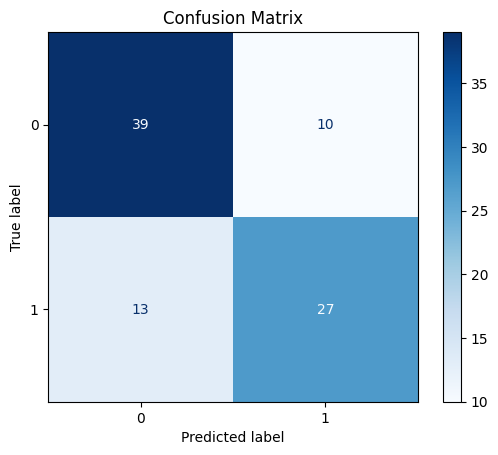

In [71]:
params = ga_svm.best_params_
svm_clf = SVC(**params).fit(X_train_scaled, y_train_binary)
y_pred = svm_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

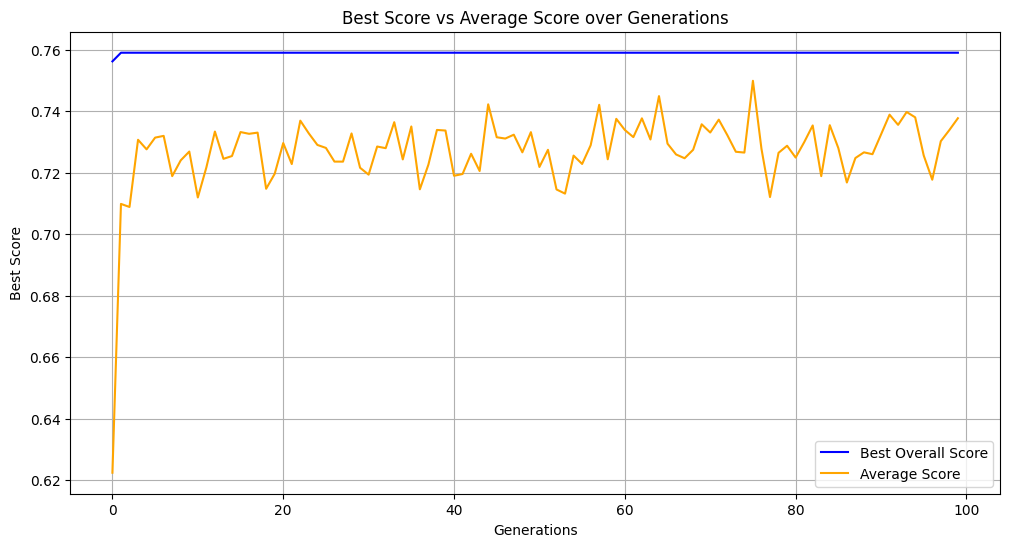

In [76]:
# Creating a graph of best scores over time 
ga_scores = ga_svm.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [40]:
svm2 = SVC()
grid_svm = GridSearchCV(svm2, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start6 = time.time()
grid_svm.fit(X_train_scaled, y_train_binary)
end6 = time.time()
print(f"Grid Search for SVM took {end6 - start6:.2f} seconds")
print(f"Best parameters from Grid Search for SVM: {grid_svm.best_params_}")
print(f"Best score from Grid Search for SVM: {grid_svm.best_score_}")


Grid Search for SVM took 940.42 seconds
Best parameters from Grid Search for SVM: {'C': np.float64(0.007196856730011514), 'coef0': np.float64(0.0), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': np.float64(0.1)}
Best score from Grid Search for SVM: 0.7590744466800805


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


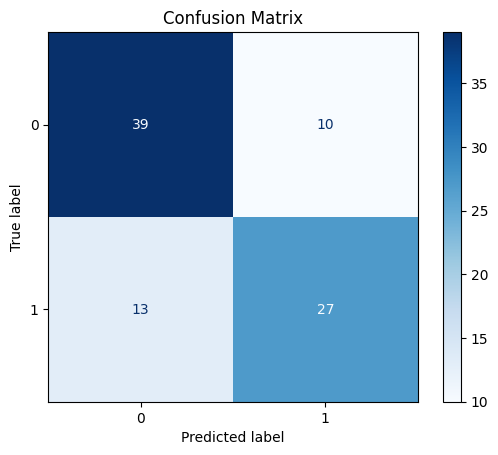

In [41]:
svm2 = grid_svm.best_estimator_
y_pred2 = svm2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [42]:
svm3 = SVC()
rand_svm = RandomizedSearchCV(svm3, svm_param_space, n_iter=7500, cv=5, n_jobs=-1, scoring='accuracy')
start7 = time.time()
rand_svm.fit(X_train_scaled, y_train_binary)
end7 = time.time()
print(f"Randomized Search for SVM took {end7 - start7:.2f} seconds")
print(f"Best parameters from Randomized Search for SVM: {rand_svm.best_params_}")
print(f"Best score from Randomized Search for SVM: {rand_svm.best_score_}")

Randomized Search for SVM took 155.49 seconds
Best parameters from Randomized Search for SVM: {'tol': np.float64(0.1), 'shrinking': False, 'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': np.float64(0.75), 'C': np.float64(0.007196856730011514)}
Best score from Randomized Search for SVM: 0.7590744466800805


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


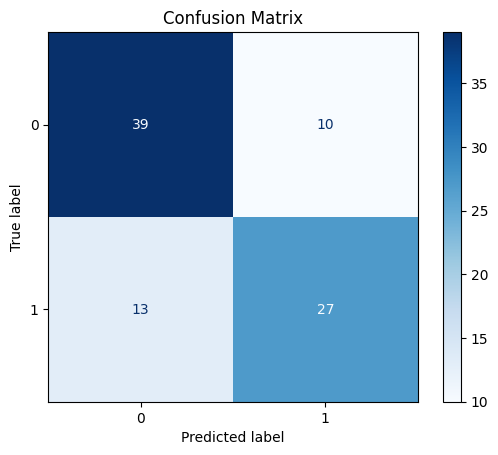

In [43]:
svm3 = rand_svm.best_estimator_
y_pred3 = svm3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [44]:
svm4 = SVC()
halving_grid_svm = HalvingGridSearchCV(svm4, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start8 = time.time()
halving_grid_svm.fit(X_train_scaled, y_train_binary)
end8 = time.time()
print(f"Halving Grid Search for SVM took {end8 - start8:.2f} seconds")
print(f"Best parameters from Halving Grid Search for SVM: {halving_grid_svm.best_params_}")
print(f"Best score from Halving Grid Search for SVM: {halving_grid_svm.best_score_}")

Halving Grid Search for SVM took 194.74 seconds
Best parameters from Halving Grid Search for SVM: {'C': np.float64(1.389495494373136), 'coef0': np.float64(0.25), 'degree': 6, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True, 'tol': np.float64(0.001)}
Best score from Halving Grid Search for SVM: 0.7582539682539682


Accuracy:  0.6853932584269663
Precision:  0.6843148850314816
Recall:  0.6853932584269663
F1 Score:  0.6845059060789398
Classification Report:
{'0': {'precision': 0.7058823529411765, 'recall': 0.7346938775510204, 'f1-score': 0.72, 'support': 49.0}, '1': {'precision': 0.6578947368421053, 'recall': 0.625, 'f1-score': 0.6410256410256411, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.681888544891641, 'recall': 0.6798469387755102, 'f1-score': 0.6805128205128206, 'support': 89.0}, 'weighted avg': {'precision': 0.6843148850314816, 'recall': 0.6853932584269663, 'f1-score': 0.6845059060789398, 'support': 89.0}}


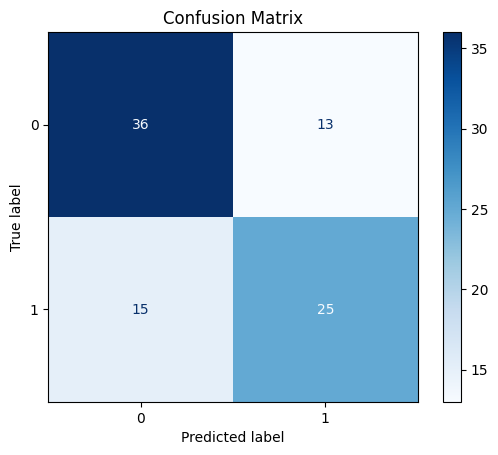

In [45]:
svm4 = halving_grid_svm.best_estimator_
y_pred4 = svm4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Logistic Regression

Note: L1 penalty is not compatible with the GridSearchCV

In [46]:
from sklearn.linear_model import LogisticRegression
from genetic_algorithm import logGA

In [47]:
logreg_param_space = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l1', 'l2'],
    'solver': {  
        'l1': ['liblinear', 'saga'],
        'l2': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
    },
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}

# Traditional searches only compatible with l2 penalty
logreg_param_space2 = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear'],
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}


##### Genetic Algorithm Search

In [73]:
lr1 = LogisticRegression()
ga_logreg = GeneticAlgorithm(
      modelToTune=lr1,
      param_space=logreg_param_space2,
      verbose=0,
      population_size=75,
      generations=100,
      mutation_prob=0.75,
      crossover_prob=0.5,
      cv=5,
      scoring='accuracy'
)
start9 = time.time()
ga_logreg.run(X_train_scaled, y_train_binary)
end9 = time.time()
print(f"Genetic Algorithm for Logistic Regression took {end9 - start9:.2f} seconds")
print(f"Best parameters found from Genetic Algorithm for Logistic Regression: {ga_logreg.best_params_}")
print(f"Best score from Genetic Algorithm for Logistic Regression: {ga_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Genetic Algorithm for Logistic Regression took 31.22 seconds
Best parameters found from Genetic Algorithm for Logistic Regression: {'C': np.float64(0.012742749857031334), 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1400, 'tol': 0.0001, 'class_weight': 'balanced', 'fit_intercept': True}
Best score from Genetic Algorithm for Logistic Regression: 0.7562173038229376


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


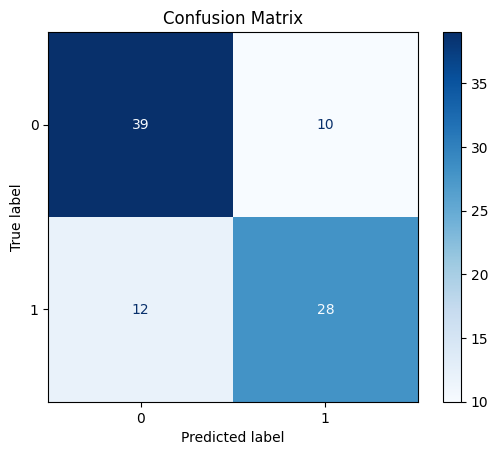

In [50]:
params = ga_logreg.best_params_
logreg_clf = LogisticRegression(**params).fit(X_train_scaled, y_train_binary)
y_pred = logreg_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

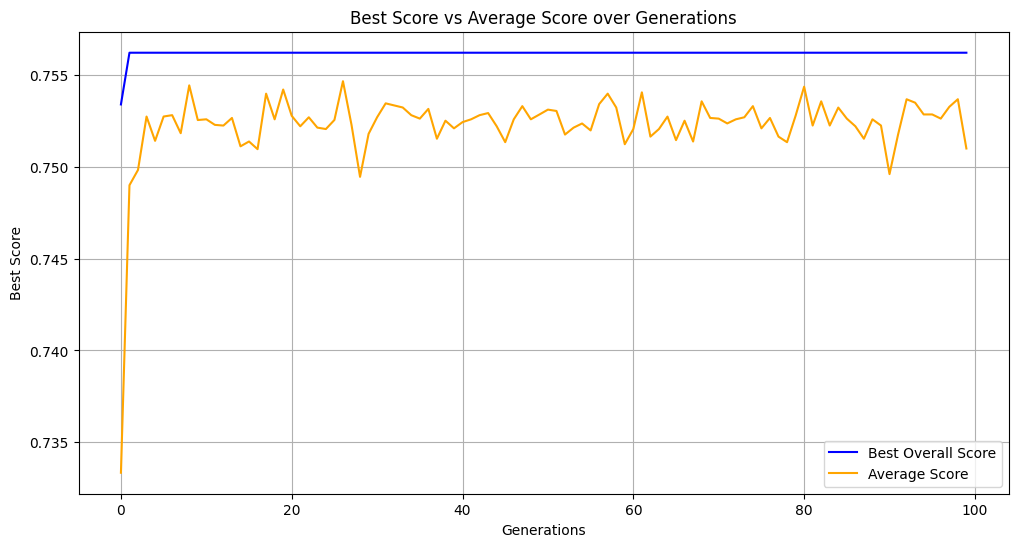

In [75]:
# Creating a graph of best scores over time 
ga_scores = ga_logreg.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [52]:
lr2 = LogisticRegression()
grid_logreg = GridSearchCV(lr2, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start10 = time.time()
grid_logreg.fit(X_train_scaled, y_train_binary)
end10 = time.time()
print(f"Grid Search for Logistic Regression took {end10 - start10:.2f} seconds")
print(f"Best parameters from Grid Search for Logistic Regression: {grid_logreg.best_params_}")
print(f"Best score from Grid Search for Logistic Regression: {grid_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Grid Search for Logistic Regression took 46.91 seconds
Best parameters from Grid Search for Logistic Regression: {'C': np.float64(0.012742749857031334), 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best score from Grid Search for Logistic Regression: 0.7562173038229376


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


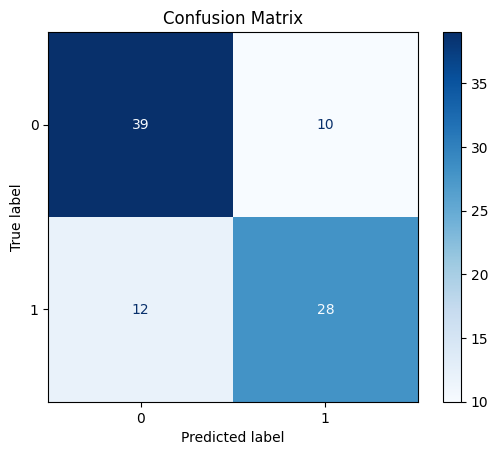

In [53]:
lr2 = grid_logreg.best_estimator_
y_pred2 = lr2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [54]:
lr3 = LogisticRegression()
rand_logreg = RandomizedSearchCV(lr3, logreg_param_space2, n_iter=7500, cv=5, n_jobs=-1, scoring='accuracy')
start11 = time.time()
rand_logreg.fit(X_train_scaled, y_train_binary)
end11 = time.time()
print(f"Randomized Search for Logistic Regression took {end11 - start11:.2f} seconds")
print(f"Best parameters from Randomized Search for Logistic Regression: {rand_logreg.best_params_}")
print(f"Best score from Randomized Search for Logistic Regression: {rand_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Randomized Search for Logistic Regression took 14.21 seconds
Best parameters from Randomized Search for Logistic Regression: {'tol': 1e-06, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1900, 'fit_intercept': True, 'class_weight': 'balanced', 'C': np.float64(0.012742749857031334)}
Best score from Randomized Search for Logistic Regression: 0.7562173038229376


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


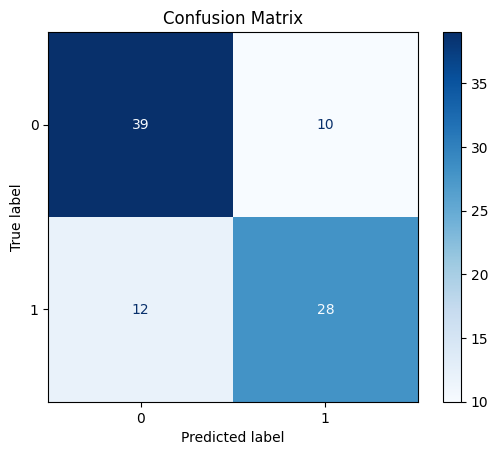

In [105]:
lr3 = rand_logreg.best_estimator_
y_pred3 = lr3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [55]:
lr4 = LogisticRegression()
halving_grid_logreg = HalvingGridSearchCV(lr4, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start12 = time.time()
halving_grid_logreg.fit(X_train_scaled, y_train_binary)
end12 = time.time()
print(f"Halving Grid Search for Logistic Regression took {end12 - start12:.2f} seconds")
print(f"Best parameters from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_params_}")
print(f"Best score from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Halving Grid Search for Logistic Regression took 45.89 seconds
Best parameters from Halving Grid Search for Logistic Regression: {'C': np.float64(0.03359818286283781), 'class_weight': None, 'fit_intercept': False, 'max_iter': 1700, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}
Best score from Halving Grid Search for Logistic Regression: 0.7471428571428571


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


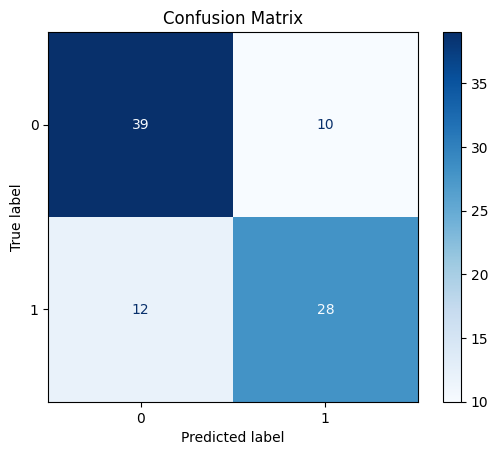

In [108]:
lr4 = halving_grid_logreg.best_estimator_
y_pred4 = lr4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)